In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow 
%matplotlib inline

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

In [ ]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

Text(0.5, 1.0, 'Number of ham and spam messages')

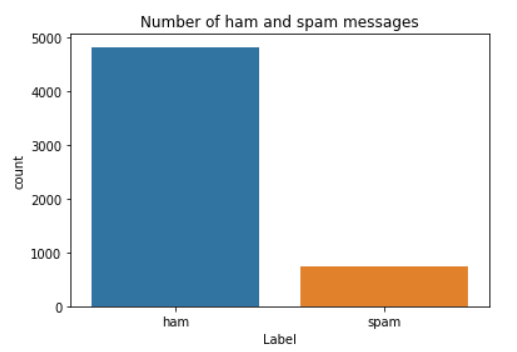

In [ ]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
df.columns

In [ ]:
data=df.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

In [ ]:
df.info()

In [ ]:
data["Message Length"]=data["Message"].apply(len)

In [ ]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

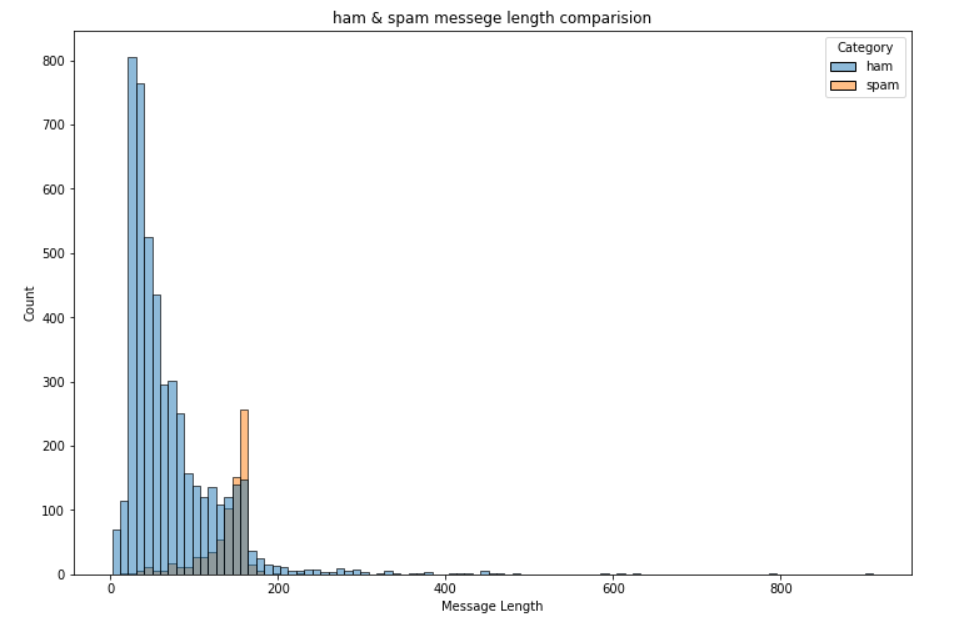

In [ ]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

In [ ]:
data.describe(include="all")

In [ ]:
data["Category"].value_counts()

In [ ]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()


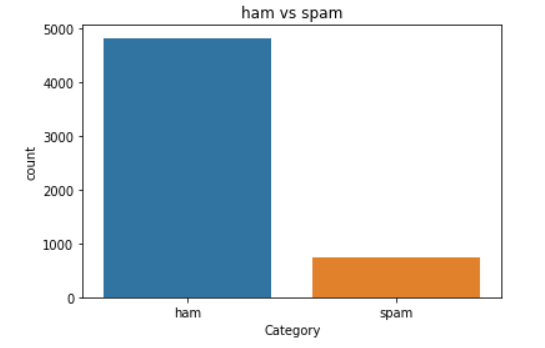

In [ ]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

In [ ]:
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])
df=data.loc[undersampled_indices]
df=df.sample(frac=1)

df=df.reset_index()
df=df.drop(
    columns=["index"],
)

In [ ]:
df.shape

In [ ]:
df["Category"].value_counts()

In [ ]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

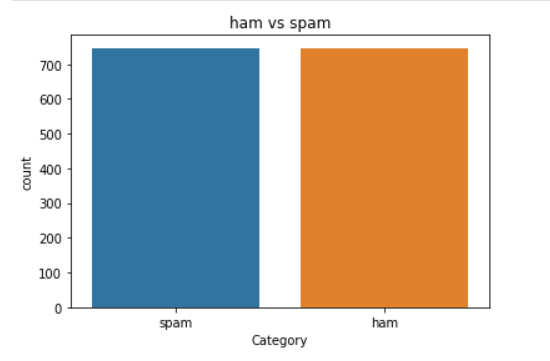

In [ ]:
df.head()

In [ ]:
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

In [ ]:
df.head()

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

In [ ]:
corpus=[]
for message in df["Message"]:
    message=re.sub("[^a-zA-Z]"," ",message)
    message=message.lower()
    message=message.split()

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

In [ ]:
df["Message Length"].describe()


In [ ]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

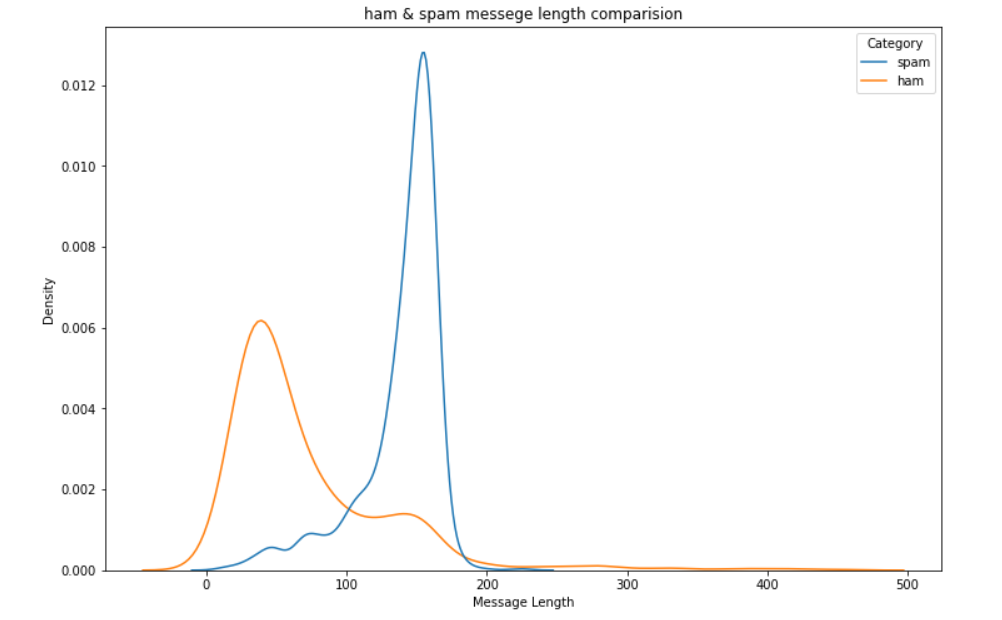

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [ ]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]

In [ ]:
df_final=pd.concat([extract_features,target],axis=1)

In [ ]:
df_final.head()

In [ ]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=37,
    test_size=0.2
)

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=37,
    test_size=0.2
)

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])